# Proyek Klasifikasi Gambar

- **Nama:** HILMI DATU ALLAM
- **Email:** hilmi.allam@gmail.com
- **ID Dicoding:** datuallam

## Import Semua Packages/Library yang Digunakan

In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil

from random import sample
import shutil
from shutil import copyfile
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
from google.colab import files

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
from PIL import Image
from skimage import io
import pandas as pd


# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf


from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input,InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model


# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



## Data Preparation

### Data Loading

In [ ]:

files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bangdatu","key":"95a4cc85b69be7841ca3ad0ae87e80d7"}'}

In [ ]:

!rm -rf Pokemon/
# Buat folder .kaggle jika belum ada
os.makedirs('/root/.kaggle', exist_ok=True)

# Pindahkan file ke folder .kaggle
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

# Ubah izin file agar hanya bisa diakses oleh owner
os.chmod('/root/.kaggle/kaggle.json', 600)

!kaggle datasets download -d ltihium123/pokemon-dataset

!unzip pokemon-dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: Pokemon/Lightning/53.jpg  
  inflating: Pokemon/Lightning/530.jpg  
  inflating: Pokemon/Lightning/531.jpg  
  inflating: Pokemon/Lightning/532.jpg  
  inflating: Pokemon/Lightning/533.jpg  
  inflating: Pokemon/Lightning/534.jpg  
  inflating: Pokemon/Lightning/535.jpg  
  inflating: Pokemon/Lightning/536.jpg  
  inflating: Pokemon/Lightning/537.jpg  
  inflating: Pokemon/Lightning/538.jpg  
  inflating: Pokemon/Lightning/539.jpg  
  inflating: Pokemon/Lightning/54.jpg  
  inflating: Pokemon/Lightning/540.jpg  
  inflating: Pokemon/Lightning/541.jpg  
  inflating: Pokemon/Lightning/542.jpg  
  inflating: Pokemon/Lightning/543.jpg  
  inflating: Pokemon/Lightning/544.jpg  
  inflating: Pokemon/Lightning/545.jpg  
  inflating: Pokemon/Lightning/546.jpg  
  inflating: Pokemon/Lightning/547.jpg  
  inflating: Pokemon/Lightning/548.jpg  
  inflating: Pokemon/Lightning/549.jpg  
  inflating: Pokemon/Lightning/55.jpg  
  inflati

**Mengganti nama folder agar lebih mudah**

### **Eksplorasi Data**

**Plot gambar sampel untuk semua kelas**

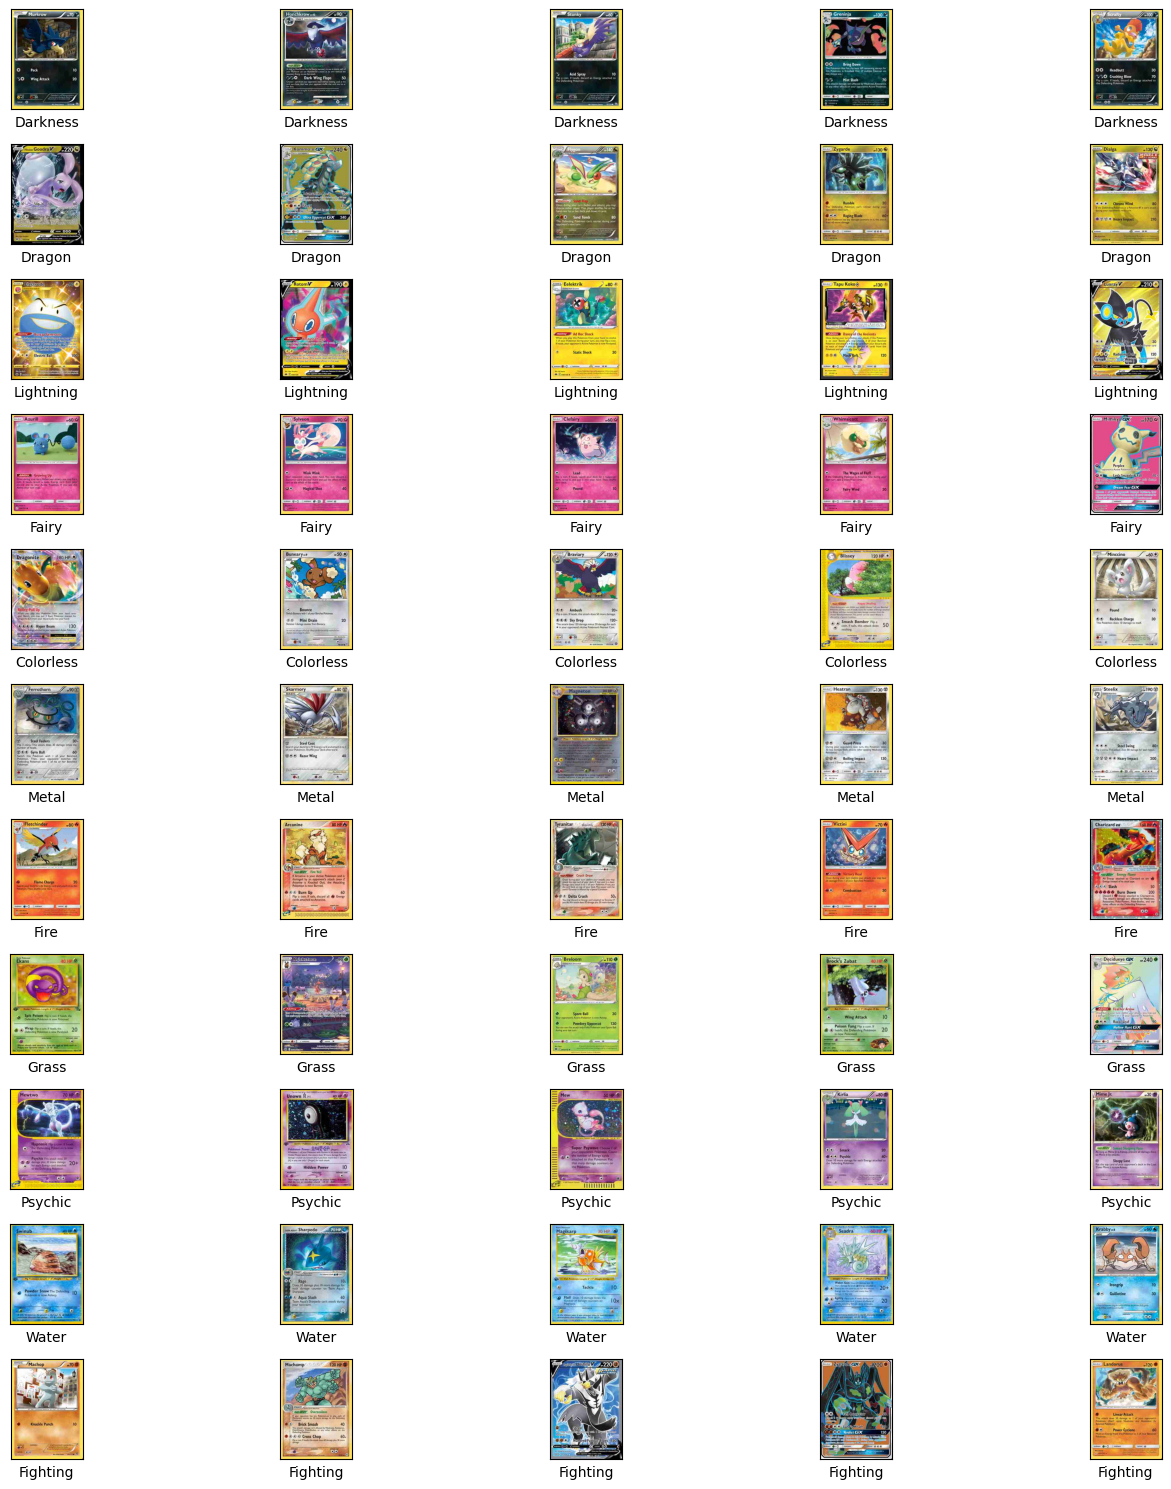

In [ ]:
#Nampilin Gambar
pokemon_image = {}
path = 'Pokemon/'

for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):  # Ensure it's a directory (class folder)
        pokemon_image[class_name] = os.listdir(class_path)

fig, axs = plt.subplots(len(pokemon_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(pokemon_image.keys()):
    images = np.random.choice(pokemon_image[class_name], 5, replace=False)
    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()


**Plot distribusi gambar di seluruh kelas**

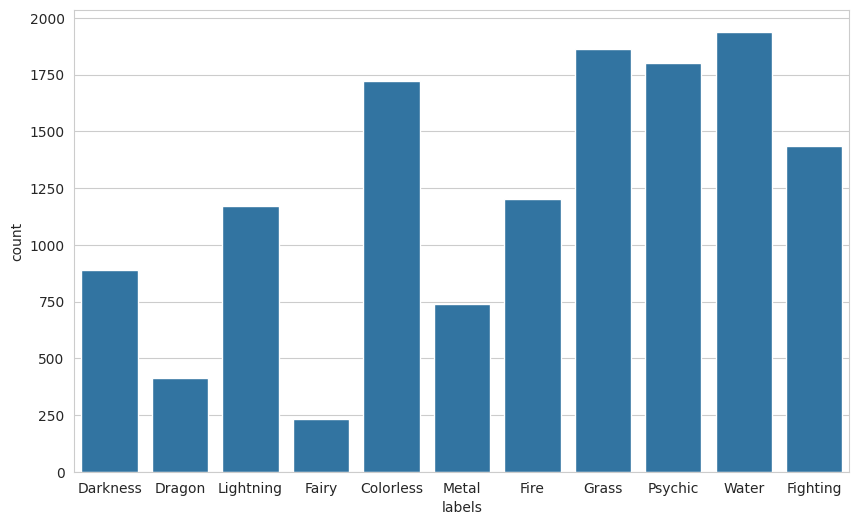

In [ ]:
pokemon_path = "Pokemon"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(pokemon_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

Label = distribution_train['labels']
plt.figure(figsize = (10,6))
sns.set_style("whitegrid")
plot_data = sns.countplot(x=Label)


In [ ]:

print("Jumlah data",distribution_train['labels'].value_counts().sum())
distribution_train['labels'].value_counts()


Jumlah data 13406


,count
labels,
Water,1939
Grass,1861
Psychic,1803
Colorless,1721
Fighting,1437
Fire,1202
Lightning,1171
Darkness,887
Metal,737


### Data Preprocessing

In [ ]:
def get_image_resolution(filepath):

        with Image.open(filepath) as img:
            return img.size

In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'Pokemon'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df['resolution'] = df['path'].apply(get_image_resolution)

In [ ]:
df

,path,file_name,labels,resolution
0,Pokemon/Darkness/185.jpg,185.jpg,Darkness,"(245, 342)"
1,Pokemon/Darkness/450.jpg,450.jpg,Darkness,"(245, 342)"
2,Pokemon/Darkness/868.jpg,868.jpg,Darkness,"(245, 342)"
3,Pokemon/Darkness/870.jpg,870.jpg,Darkness,"(245, 342)"
4,Pokemon/Darkness/822.jpg,822.jpg,Darkness,"(245, 342)"
...,...,...,...,...
13401,Pokemon/Fighting/351.jpg,351.jpg,Fighting,"(245, 342)"
13402,Pokemon/Fighting/369.jpg,369.jpg,Fighting,"(240, 330)"
13403,Pokemon/Fighting/1368.jpg,1368.jpg,Fighting,"(245, 342)"
13404,Pokemon/Fighting/345.jpg,345.jpg,Fighting,"(245, 342)"


In [ ]:
# Misal get_image_resolution mengembalikan tuple (width, height)
df[['x', 'y']] = pd.DataFrame(df['resolution'].tolist(), index=df.index)

# Hitung rata-rata resolusi
avg_x = df['x'].mean()
avg_y = df['y'].mean()

print(f"Average Resolution - X: {avg_x:.2f}, Y: {avg_y:.2f}")


Average Resolution - X: 244.36, Y: 340.43


**Saya menyadari label tipe pokemon konsisten pada pojok kanan yaitu sebuah icon maka kita crop data untuk mengambil bagian itu saja**

In [ ]:

mypath = 'Pokemon'
output_path = 'Pokemon_cropped'
# buat output_path dir kalo gk ada
if not os.path.exists(output_path):
    os.makedirs(output_path)

file_name = []
labels = []
full_path = []

#
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# 
def crop_top_right(image_path, output_dir):
    try:
        with Image.open(image_path) as img:
            # img = img.convert('RGB')
            width, height = img.size

            # pakai rata rata resolusi tadi
            crop_width = int(avg_x*0.2)
            crop_height = int(avg_y*0.1)
            top_right = img.crop((width - crop_width, 0, width, crop_height))


            relative_path = os.path.relpath(os.path.dirname(image_path), mypath)
            output_subdir = os.path.join(output_dir, relative_path)
            if not os.path.exists(output_subdir):
                os.makedirs(output_subdir)

            # save
            output_file = os.path.join(output_subdir, os.path.basename(image_path))
            top_right.save(output_file)
            return output_file
    except :
        return image_path
def my_crop_function(x):
    return crop_top_right(x, output_path)

df = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})

# update path ke path baru
df['path'] = df['path'].apply(my_crop_function)
# df['path'] = df['path'].apply(lambda x: crop_top_right(x, output_path))


print(df)

                                    path file_name    labels
0       Pokemon_cropped/Darkness/185.jpg   185.jpg  Darkness
1       Pokemon_cropped/Darkness/450.jpg   450.jpg  Darkness
2       Pokemon_cropped/Darkness/868.jpg   868.jpg  Darkness
3       Pokemon_cropped/Darkness/870.jpg   870.jpg  Darkness
4       Pokemon_cropped/Darkness/822.jpg   822.jpg  Darkness
...                                  ...       ...       ...
13401   Pokemon_cropped/Fighting/351.jpg   351.jpg  Fighting
13402   Pokemon_cropped/Fighting/369.jpg   369.jpg  Fighting
13403  Pokemon_cropped/Fighting/1368.jpg  1368.jpg  Fighting
13404   Pokemon_cropped/Fighting/345.jpg   345.jpg  Fighting
13405   Pokemon_cropped/Fighting/894.jpg   894.jpg  Fighting

[13406 rows x 3 columns]


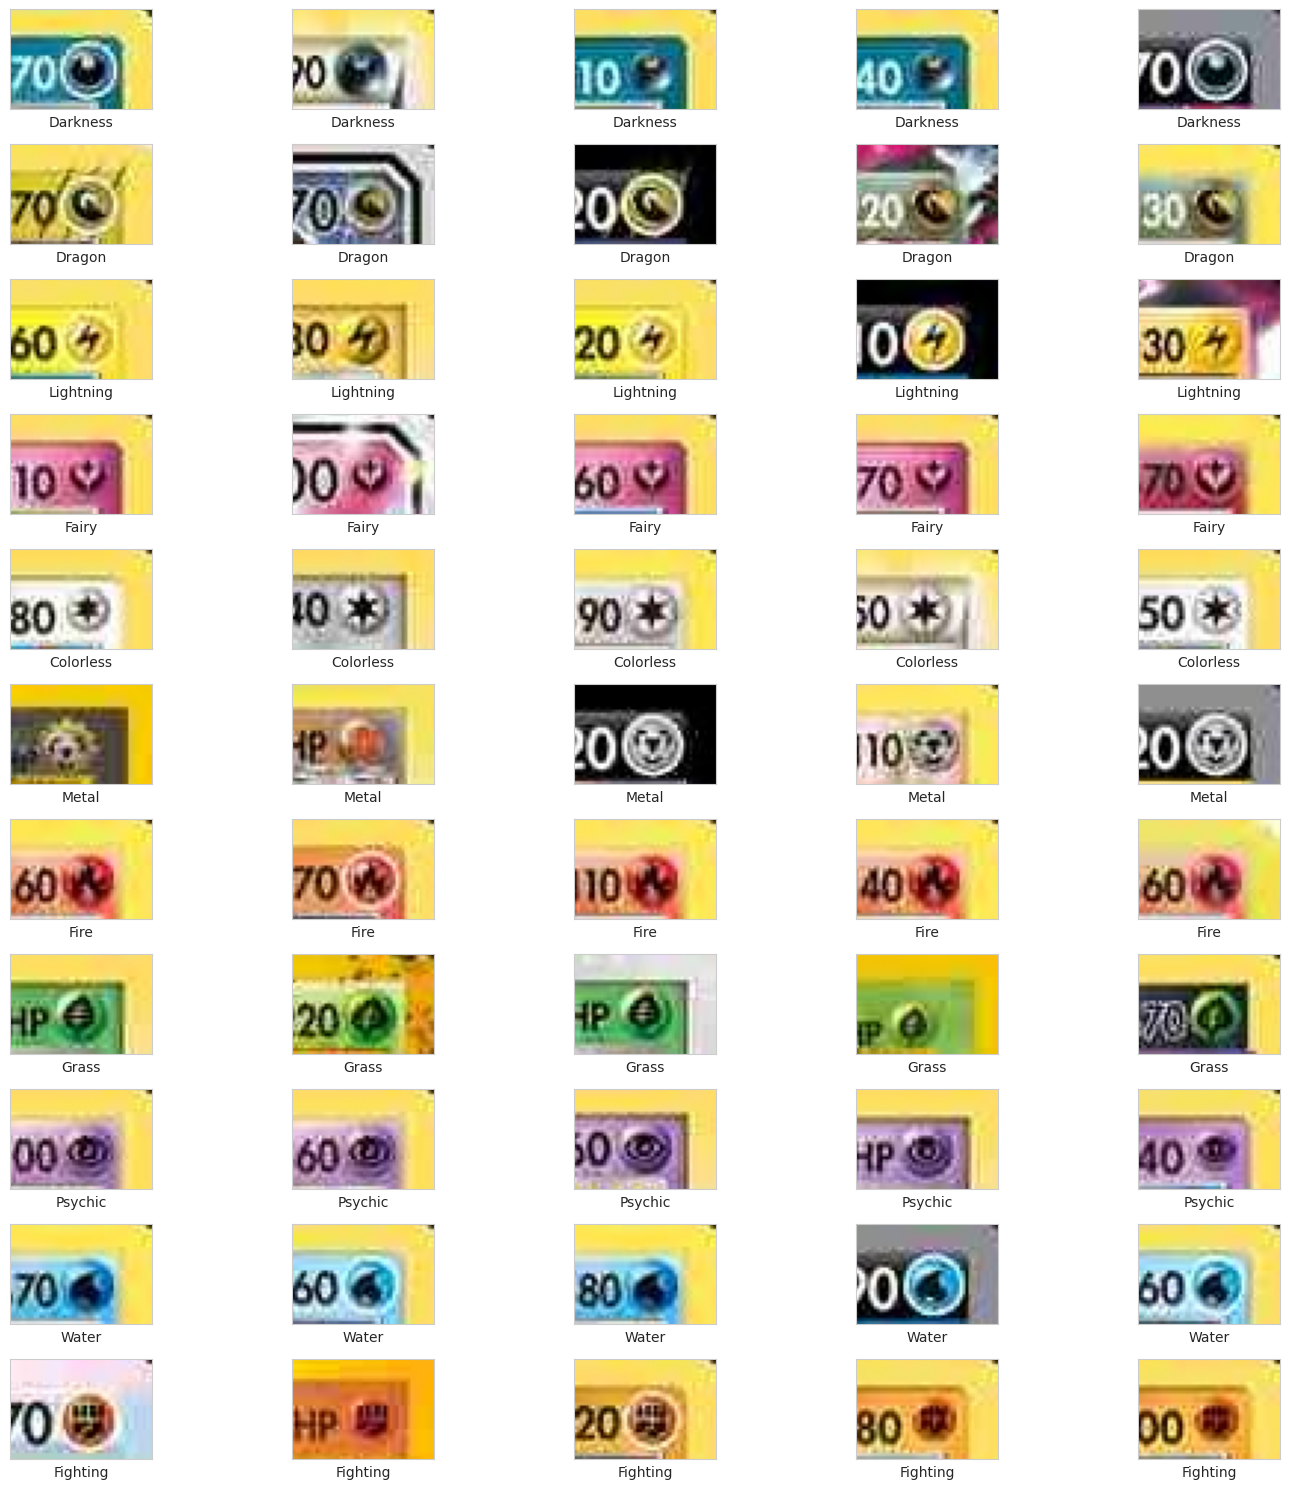

In [ ]:

# Lihat hasil crop
pokemon_image = {}
path = 'Pokemon_cropped/'


for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        pokemon_image[class_name] = os.listdir(class_path)

fig, axs = plt.subplots(len(pokemon_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(pokemon_image.keys()):
    images = np.random.choice(pokemon_image[class_name], 5, replace=False)
    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()


### Split Dataset

In [ ]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test untuk validation set akan di lakukan di image data generator
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [ ]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [ ]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 10724
test size 2682


In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)
print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')

# Cek sample data
print(df_all.sample(5))


set    labels   
test   Colorless     326
       Darkness      170
       Dragon         87
       Fairy          50
       Fighting      291
       Fire          233
       Grass         405
       Lightning     214
       Metal         139
       Psychic       369
       Water         398
train  Colorless    1395
       Darkness      717
       Dragon        328
       Fairy         183
       Fighting     1146
       Fire          969
       Grass        1456
       Lightning     957
       Metal         598
       Psychic      1434
       Water        1541
dtype: int64 

                                   path     labels    set
11696  Pokemon_cropped/Lightning/21.jpg  Lightning   test
13374      Pokemon_cropped/Dragon/0.jpg     Dragon   test
3779      Pokemon_cropped/Grass/430.jpg      Grass  train
2186      Pokemon_cropped/Grass/745.jpg      Grass  train
7005   Pokemon_cropped/Psychic/1729.jpg    Psychic  train


In [ ]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "Pokemon_cropped"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder contoh ntar set train dan labels fire Dataset-final/train/fire
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

### Image Data Generator

In [ ]:
train_directory="Dataset-Final/train/"
test_directory="Dataset-Final/test/"

train_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

train_data = train_datagen.flow_from_directory(
    train_directory,
    target_size=(48, 34),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

validation_data = train_datagen.flow_from_directory(
    train_directory,
    target_size=(48, 34),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

# Test
test_datagen = ImageDataGenerator(rescale=1./255.)

test_data = test_datagen.flow_from_directory(
    test_directory,
    target_size=(48, 34),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 8584 images belonging to 11 classes.
Found 2140 images belonging to 11 classes.
Found 2682 images belonging to 11 classes.


## Modelling

In [ ]:

model = Sequential([
    Input(shape=(48, 34, 3)),

    Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),



    GlobalAveragePooling2D(),

    Dense(64, activation='relu'),
    Dropout(0.5),

    Dense(32, activation='relu'),

    Dense(train_data.num_classes, activation="softmax")
])


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 34, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 34, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 17, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 8, 128)     │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 8, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,211 (918.79 KB)

 Trainable params: 234,571 (916.29 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
class callback_model(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.96 and logs.get('val_accuracy')>0.95):
            print("\n\nTarget tercapai\n")
            self.model.stop_training = True

In [ ]:
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=["accuracy"])
callbacks = [
    callback_model()
]

In [ ]:
history = model.fit(
    train_data,
    epochs=200,
    validation_data=validation_data,
    callbacks=callbacks
)

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


269/269 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - accuracy: 0.5598 - loss: 2.8917 - val_accuracy: 0.1921 - val_loss: 3.9539
Epoch 2/200
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9076 - loss: 0.7481 - val_accuracy: 0.7879 - val_loss: 1.0106
Epoch 3/200
269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9563 - loss: 0.4840 - val_accuracy: 0.5425 - val_loss: 2.0135
Epoch 4/200
267/269 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9634 - loss: 0.4471

Target tercapai

269/269 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9635 - loss: 0.4472 - val_accuracy: 0.9598 - val_loss: 0.4688


## Evaluasi dan Visualisasi

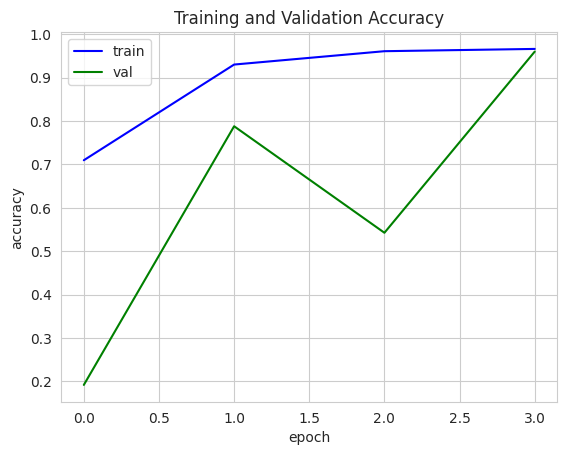

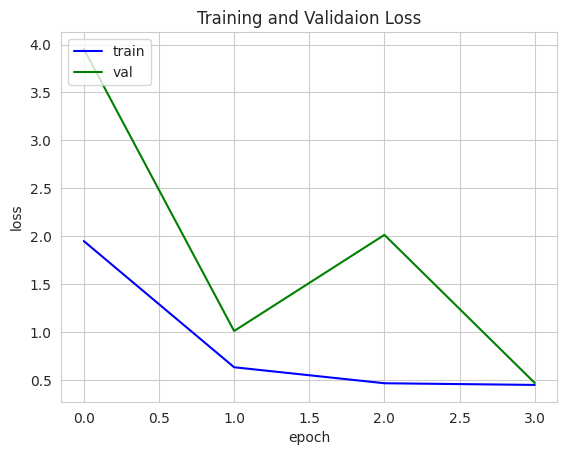

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b')
plt.plot(epochs, val_acc, 'g')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'g')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9633 - loss: 0.4364
Test Accuracy: 0.9594


## Konversi Model

In [42]:
# Simpan ke Keras format
model.save("model.h5")
model.save("model.keras")

# Simpan ke SavedModel format (untuk TFLite / TFJS)
model.export("saved_model")
shutil.make_archive("/content/saved_model", 'zip', 'saved_model')
files.download('/content/saved_model.zip')
# Konversi ke TF Lite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)




Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 34, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  136699413474832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136699413471184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136699413477328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136699413472720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136699413478480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136699413478864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136699413472912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136699413472528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136699413479056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136699413470608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136699413478288: Tens

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Install tensorflowjs

!pip install tensorflowjs
# Convert model.h5 to model
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-05-04 21:59:33.214583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746395973.235703   11815 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174

In [41]:
shutil.make_archive("/content/tfjs_model", 'zip', 'tfjs_model')
files.download('/content/tfjs_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

In [ ]:
# Fungsi crop sesuai yang Anda berikan
def crop_top_right(image_path):

      with Image.open(image_path) as img:
            width, height = img.size
            crop_width = int(avg_x * 0.2)
            crop_height = int(avg_y * 0.1)
            top_right = img.crop((width - crop_width, 0, width, crop_height))
            return top_right



# Label kelas
class_labels = [
    'Colorless', 'Darkness', 'Dragon', 'Fairy', 'Fighting', 'Fire',
    'Grass', 'Lightning', 'Metal', 'Psychic', 'Water'
]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


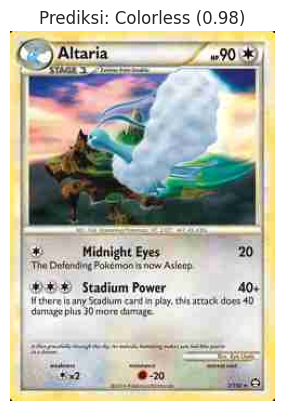

In [ ]:



# Load model
model = load_model('/content/model.h5')

# Path gambar untuk inference
img_path = '/content/Pokemon/Colorless/1.jpg'
# Crop gambar
cropped_img = crop_top_right(img_path)

# Preprocessing
cropped_img = cropped_img.resize((48, 34))
img_array = img_to_array(cropped_img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Inference
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)
confidence = np.max(predictions)
predicted_label = class_labels[predicted_class]

image = Image.open(img_path)
# Visualisasi hasil
plt.imshow(image)
plt.title(f"Prediksi: {predicted_label} ({confidence:.2f})")
plt.axis('off')
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


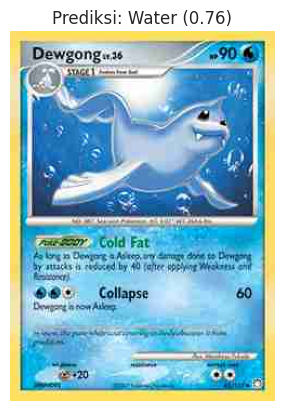

In [ ]:



# Load model
model = load_model('/content/model.h5')

# Path gambar untuk inference
img_path = '/content/Pokemon/Water/1003.jpg'

# Crop gambar
cropped_img = crop_top_right(img_path)

# Preprocessing
cropped_img = cropped_img.resize((48, 34))
img_array = img_to_array(cropped_img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Inference
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)
confidence = np.max(predictions)
predicted_label = class_labels[predicted_class]

# Visualisasi hasil
image = Image.open(img_path)
plt.imshow(image)
plt.title(f"Prediksi: {predicted_label} ({confidence:.2f})")
plt.axis('off')
plt.show()

